In [147]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy as cvx
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from tqdm import tqdm
from scipy.stats import gaussian_kde
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,14)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)

libs_path = '/Users/richard.wuebker/Projects/backtesting/libs'
if libs_path not in sys.path:
    sys.path.append(libs_path)

    
from risk_model import RiskModelPCA
from optimal_holdings import OptimalHoldingsCVX
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [73]:
dl = DataLoader(prices_dir='../price_data_utils/prices', info_dir='../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../price_data_utils/cached')
dl.load_data()
data = dl.data

Prediction Date: 2019-08-09


In [74]:
hp = HistoricalPrices(prices_dir='../price_data_utils/prices', 
                      cached_dir='../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [75]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,1990-01-02,17.947027,17.527565,17.557526,17.947027,626200.0,7.267582,KMB
1,1990-01-03,17.976990,17.827181,17.976990,17.887104,749200.0,7.243319,KMB
2,1990-01-04,17.976990,17.797220,17.857143,17.857143,439700.0,7.231189,KMB
3,1990-01-05,17.857143,17.617449,17.797220,17.737297,712500.0,7.182656,KMB
4,1990-01-08,17.917067,17.707335,17.737297,17.917067,495600.0,7.255455,KMB


In [76]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=5)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
new_p = transform_prices(prices, '2016-01-05')

In [77]:
# to make the index of data we have with sector the same as in returns and prices

sector_data = data['sector']
index_ = sector_data.index.intersection(new_p.columns)
sector_data = sector_data.loc[index_]
p = new_p.loc[:, index_].copy() # to use only the stocks that are in sector_data
sectors = sector_data.unique()

In [78]:
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
print(sector_data.shape)
print(p.shape)

(1257, 741)
(741,)
(1258, 741)


In [79]:
p.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,16.319235,25.350000,50.676487,91.209999,692.690002,59.998005,28.536177,40.534866,70.415245,34.523262,...,14.976269,77.790001,17.154980,33.694031,43.528183,23.909542,14.824180,6.94250,151.752335,16.587673
2011-01-06,16.460661,25.750000,50.676487,89.559998,718.400024,62.723892,28.326279,40.797176,69.994743,34.397305,...,14.842355,76.050003,16.839489,33.711502,43.555824,23.958487,14.856651,6.83000,150.116272,16.470205
2011-01-07,16.476372,25.950001,50.264294,89.133331,735.150024,62.590939,28.334854,40.758602,70.200493,34.976746,...,14.686119,75.209999,16.681742,33.589188,43.472923,24.031902,14.669928,6.69375,148.875351,16.315643
2011-01-10,16.334949,26.200001,50.342079,90.526665,749.960022,62.932850,28.647541,41.267784,70.057358,35.111115,...,14.358768,74.680000,16.497704,33.807583,44.891319,24.553984,14.678050,6.90250,151.096298,16.290915
2011-01-11,16.405655,25.690001,50.715374,93.663330,751.900024,63.474232,29.354307,41.653553,72.347855,35.279057,...,14.336452,76.300003,16.333384,33.982292,45.572895,24.456089,14.507563,6.79875,152.874680,16.303284


In [80]:
p.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-29,24.640928,59.299999,66.267441,184.456665,1650.000000,141.577072,48.883698,29.317432,31.023300,45.610756,...,29.112070,136.169998,34.340061,73.815681,75.976669,35.107853,39.816341,41.125000,314.309814,29.093164
2015-12-30,24.427971,57.509998,65.351830,184.169998,1649.540039,140.273254,48.753433,29.024263,29.830099,45.245197,...,28.986509,135.639999,34.271770,73.255249,75.430962,35.071419,39.375340,40.480000,312.891907,29.008694
2015-12-31,24.099659,57.299999,64.807915,182.053329,1643.000000,139.751724,48.278931,29.077566,30.792358,44.842140,...,28.520142,134.580002,34.186417,72.770805,74.725288,34.515739,39.672337,40.305000,311.492279,28.831297
2016-01-04,23.616772,55.610001,63.629417,182.463333,1555.660034,137.626907,48.325451,29.886017,31.100277,44.710915,...,27.910280,130.350006,33.768162,71.944405,73.135201,34.415535,39.096333,39.830002,304.704834,28.451166
2016-01-05,23.509462,55.060001,63.892326,183.986664,1594.089966,137.800766,48.167278,30.179193,31.591042,44.542198,...,28.170368,129.809998,34.382748,71.241478,73.530373,33.559250,39.078335,40.075001,305.491516,28.755270


In [81]:
# create a risk model for 2011 data
returns_2011 = returns.loc[returns.index.year == 2011]
print(returns_2011.shape)
returns_2011.head()

(249, 741)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-06,0.008666,0.015779,0.000000,-0.018090,0.037116,0.045433,-0.007356,0.006471,-0.005972,-0.003648,...,-0.008942,-0.022368,-0.018391,0.000519,0.000635,0.002047,0.002190,-0.016205,-0.010781,-0.007082
2011-01-07,0.000954,0.007767,-0.008134,-0.004764,0.023316,-0.002120,0.000303,-0.000946,0.002939,0.016846,...,-0.010526,-0.011045,-0.009368,-0.003628,-0.001903,0.003064,-0.012568,-0.019949,-0.008266,-0.009384
2011-01-10,-0.008583,0.009634,0.001548,0.015632,0.020146,0.005463,0.011035,0.012493,-0.002039,0.003842,...,-0.022290,-0.007047,-0.011032,0.006502,0.032627,0.021725,0.000554,0.031186,0.014918,-0.001516
2011-01-11,0.004328,-0.019466,0.007415,0.034649,0.002587,0.008603,0.024671,0.009348,0.032695,0.004783,...,-0.001554,0.021693,-0.009960,0.005168,0.015183,-0.003987,-0.011615,-0.015031,0.011770,0.000759
2011-01-12,0.011494,0.008174,0.021469,0.004342,0.018779,-0.010175,0.002043,0.005927,0.013975,0.014044,...,-0.002076,0.005898,-0.003622,0.013419,0.014956,0.006004,0.019026,0.011583,0.002171,0.008722


In [82]:
risk_model = RiskModelPCA(returns_2011, 20)

<BarContainer object of 20 artists>

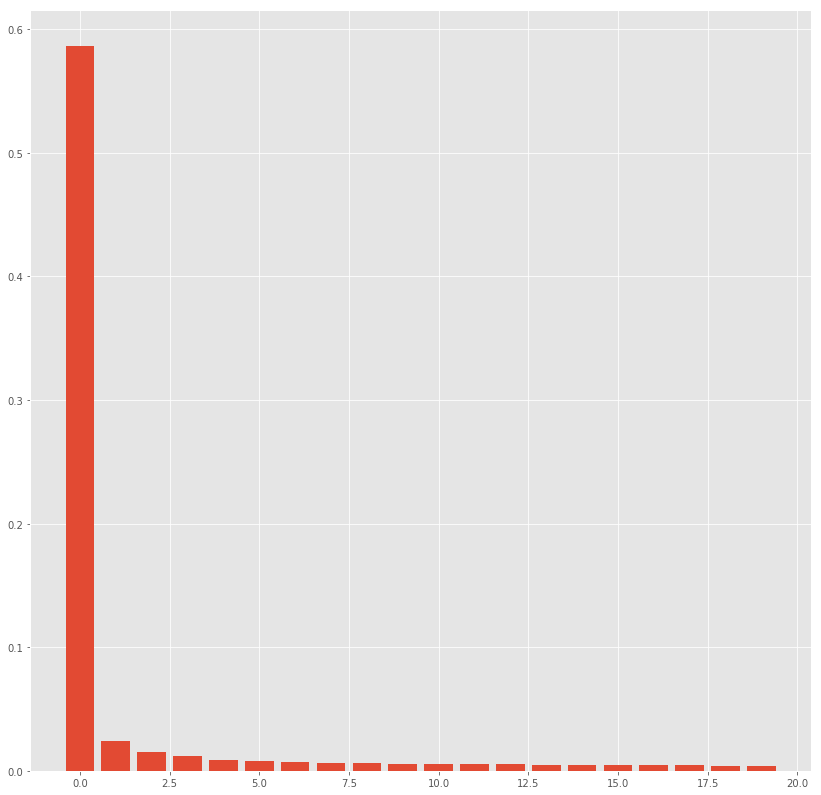

In [83]:
plt.bar(np.arange(risk_model.n_components), risk_model.pca.explained_variance_ratio_)

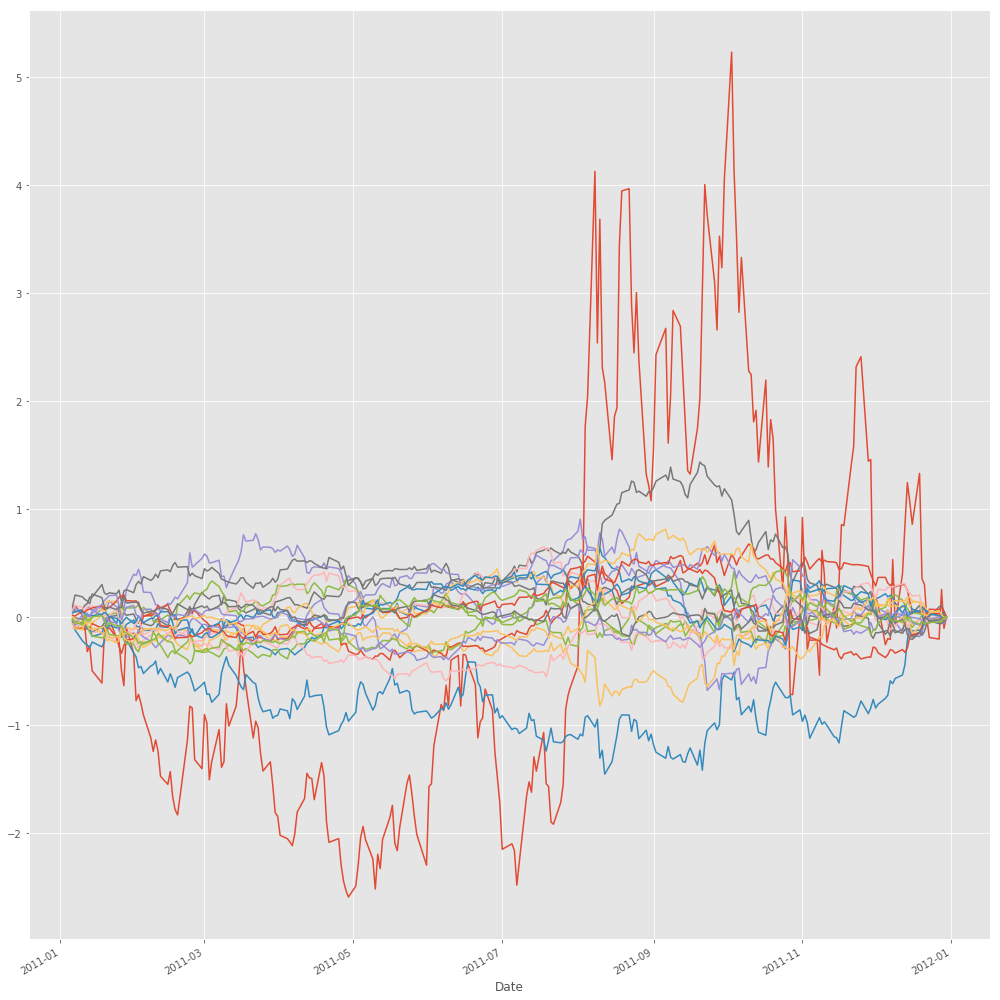

In [84]:
# looking at factor returns
risk_model.factor_returns.cumsum().plot(legend=False)
plt.tight_layout()

In [85]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()

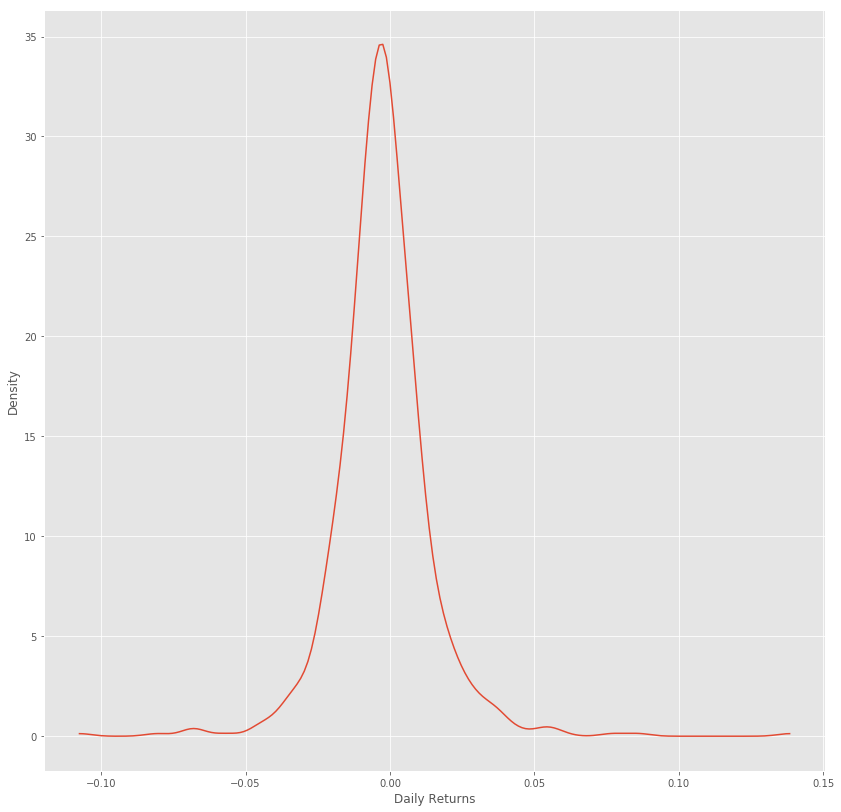

In [86]:
density_plot(risk_model.unwinz_returns.iloc[0])

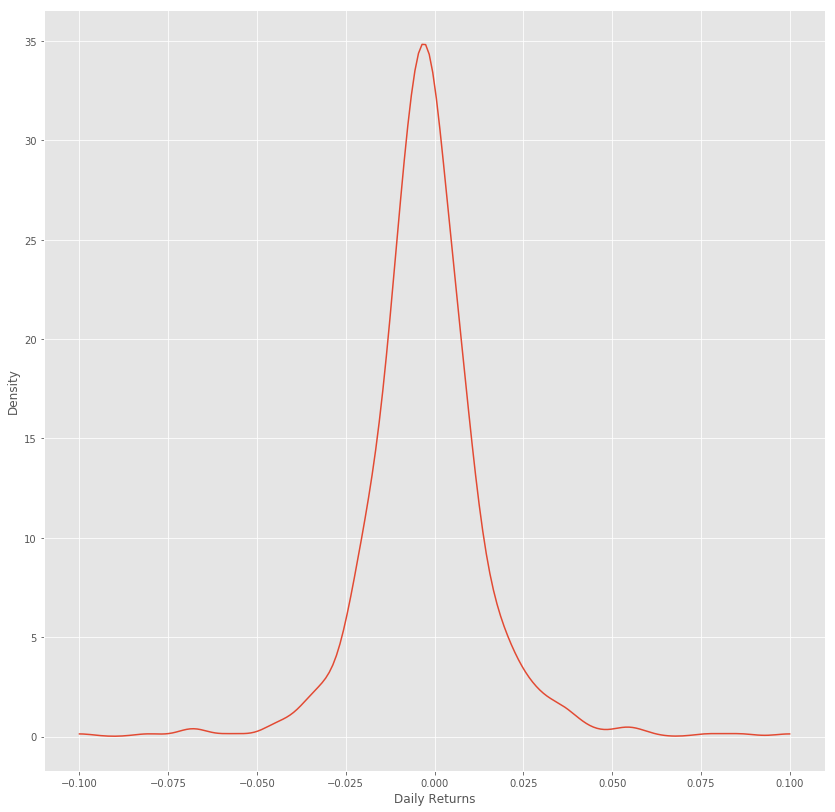

In [87]:
density_plot(risk_model.returns.iloc[0])

In [88]:
holdings = [50000000 / len(returns_2011.columns)] * len(returns_2011.columns)
holdings[:5]

[67476.38326585694,
 67476.38326585694,
 67476.38326585694,
 67476.38326585694,
 67476.38326585694]

In [89]:
risk_model.predict_portfolio_risk(holdings)

186099218691818.44

In [90]:
risk_model.predict_portfolio_risk_opt(holdings)

186099218691818.47

In [91]:
holdings = [1.0 / len(returns_2011.columns)] * len(returns_2011.columns)
holdings[:5]

[0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139]

In [92]:
np.sqrt(risk_model.predict_portfolio_risk(holdings))

0.27283637491494306

In [93]:
np.sqrt(risk_model.predict_portfolio_risk_opt(holdings))

0.27283637491494295

In [94]:
def create_momentum_factor(prices, sector_data):

    # demean by sector
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [95]:
momentum = create_momentum_factor(p, sector_data)
momentum.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.471847,-1.326777,-0.228916,1.691173,-0.369068,1.588395,1.130563,0.728793,-1.200640,1.032457,...,0.261618,-0.686747,0.149496,-0.158839,-1.051144,1.621097,-1.130563,1.214655,0.126137,-0.172855
2012-01-06,-0.476518,-1.382838,-0.196213,1.686502,-0.583969,1.532334,1.130563,0.752152,-1.256701,1.027785,...,0.355053,-0.551266,0.219572,-0.182198,-1.004426,1.588395,-1.065159,1.275388,0.233587,-0.149496
2012-01-09,-0.513892,-1.448242,-0.294320,1.663143,-0.738136,1.513647,1.172609,0.752152,-1.130563,1.023113,...,0.327022,-0.537251,0.303664,-0.144824,-0.976396,1.588395,-1.027785,1.340792,0.154168,0.070076
2012-01-10,-0.551266,-1.508975,-0.163511,1.649128,-0.896976,1.555693,1.125892,0.569953,-1.191296,1.027785,...,0.415786,-0.560610,0.336366,-0.228916,-1.097861,1.522990,-1.069831,1.261372,0.116794,-0.004672
2012-01-11,-0.527908,-1.457586,-0.303664,1.649128,-0.873617,1.504303,1.083846,0.284977,-1.219327,1.018441,...,0.485862,-0.551266,0.355053,-0.228916,-1.079174,1.518319,-0.995083,1.331449,0.130809,-0.121465


In [96]:
risk_model.returns.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-23,0.018753,-0.020237,0.011614,0.021882,-0.001494,0.001786,0.008702,0.024272,-0.005726,0.008050,...,0.011543,0.000939,0.000381,0.009111,0.004898,0.008929,0.013871,0.036691,0.016639,0.003724
2011-12-27,0.005956,-0.032746,-0.001218,0.012695,-0.004059,-0.002773,0.003299,0.008989,-0.002399,0.011224,...,0.010373,0.000402,0.013318,-0.008482,0.004874,0.006110,-0.001244,0.007106,-0.003195,0.005059
2011-12-28,-0.022605,-0.013021,-0.019680,-0.012450,-0.009119,-0.017680,-0.019558,-0.014253,-0.019243,-0.020704,...,-0.006673,-0.018226,-0.015020,-0.009106,-0.013743,0.002304,-0.005604,-0.015604,-0.007872,-0.003691
2011-12-29,0.004956,-0.005805,0.019009,0.018200,0.028328,0.001415,0.019430,0.011173,0.018476,0.023104,...,0.011886,0.012012,0.012581,0.029518,0.012295,0.012954,0.028178,-0.009786,0.016776,0.002021
2011-12-30,-0.009315,0.001592,-0.007148,-0.006480,0.001460,-0.017569,-0.005845,-0.008125,-0.004655,-0.004900,...,-0.003575,-0.001214,-0.006777,0.003787,-0.000810,0.001857,-0.016444,-0.000696,-0.006466,-0.011092


In [97]:
date_ = pd.to_datetime('2011-12-30')
date_

Timestamp('2011-12-30 00:00:00')

In [98]:
alpha_vector = momentum.loc['2012-01-05', :]
len(alpha_vector)

741

In [99]:
previous = np.asarray(holdings)
len(previous)

741

In [193]:
class OptimalHoldingsCVX:

    def __init__(self, risk_model, alpha_vector, previous, risk_cap=0.05, factor_max=10.0, aum=50e6, lambda_reg=0.50,
                 factor_min=-10.0, weights_max=0.015, weights_min=-0.015, risk_aversion=1.0e-6):

        self.risk_model = risk_model
        self.alpha_vector = alpha_vector
        self.previous = previous
        self.risk_cap = risk_cap
        self.factor_min = factor_min
        self.factor_max = factor_max
        self.weights_min = weights_min
        self.weights_max = weights_max
        self.risk_aversion = risk_aversion
        self.aum = aum
        self.notional_risk = risk_cap * aum
        self.lambda_reg = lambda_reg

    def _get_obj(self):
        ra = self.risk_aversion
        Q = self.risk_model.Q # Q is k x N
        ivv = self.risk_model.i_var_vector
        av = self.alpha_vector.values.reshape(len(self.alpha_vector), 1)
        h0 = self.previous
        lambda_vector = np.ones((len(av), 1)) * 0.1/2000000
        lv = lambda_vector
        h1 = cvx.Variable(len(self.alpha_vector))
        m = ra * 0.50
        #func = m * cvx.sum((Q @ h1)**2) + m * ((h1**2) @ ivv) - (h1 @ av) + ((h1-h0)**2) @ lv + self.lambda_reg * cvx.norm(h1, 2)
        func = -(h1 @ av) + self.lambda_reg * cvx.norm(h1, 2)
        func = cvx.Minimize(func)
        prob = cvx.Problem(func, [])
        print(prob.is_dcp())
        #av = -av
        self.h1 = h1
        #func = cvx.Minimize(av.T @ h1 + self.lambda_reg * cvx.norm(h1, 2))
        self.obj_func = func

    def _get_constraints(self):
        risk = self.get_risk()
        c = []
        h1 = self.h1
        factor_exposures = self.risk_model.factor_exposures
        c.append(risk <= self.risk_cap ** 2)
        c.append(h1 <= self.weights_max)
        c.append(h1 >= self.weights_min)
        c.append(sum(h1) == 0)
        c.append(factor_exposures.T @ h1 <= self.factor_max)
        c.append(factor_exposures.T @ h1 >= self.factor_min)
        c.append(sum(cvx.abs(h1)) <= 1.0)
        return c

    def get_risk(self):
        Q = self.risk_model.Q
        h1 = self.h1
        ivv = self.risk_model.i_var_vector
        result = cvx.sum((Q @ h1)**2) + (h1**2) @ ivv
        ivm = self.risk_model.i_var_matrix.values
        f = self.risk_model.factor_exposures.T @ h1
        X = self.risk_model.factor_cov_matrix
        return cvx.quad_form(f, X) + cvx.quad_form(h1, ivm)

    def find(self):
        obj_func = self._get_obj()
        h1 = self.h1
        prob = cvx.Problem(self.obj_func, self._get_constraints())
        print(prob.is_dcp())
        prob.solve(max_iters=1000)
        optimal_weights = np.asarray(h1.value).flatten()
        df = pd.DataFrame(optimal_weights, index=self.alpha_vector.index)
        return df

In [101]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, previous, lambda_reg=0.0)

In [102]:
oh._get_obj()
oh.obj_func

True


Minimize(Expression(AFFINE, UNKNOWN, (1,)))

In [103]:
risk_model.Q.shape

(20, 741)

In [104]:
oh.get_risk()

Expression(CONVEX, NONNEGATIVE, (1, 1))

In [105]:
result = oh.find()

True


In [106]:
result.shape

(741, 1)

/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


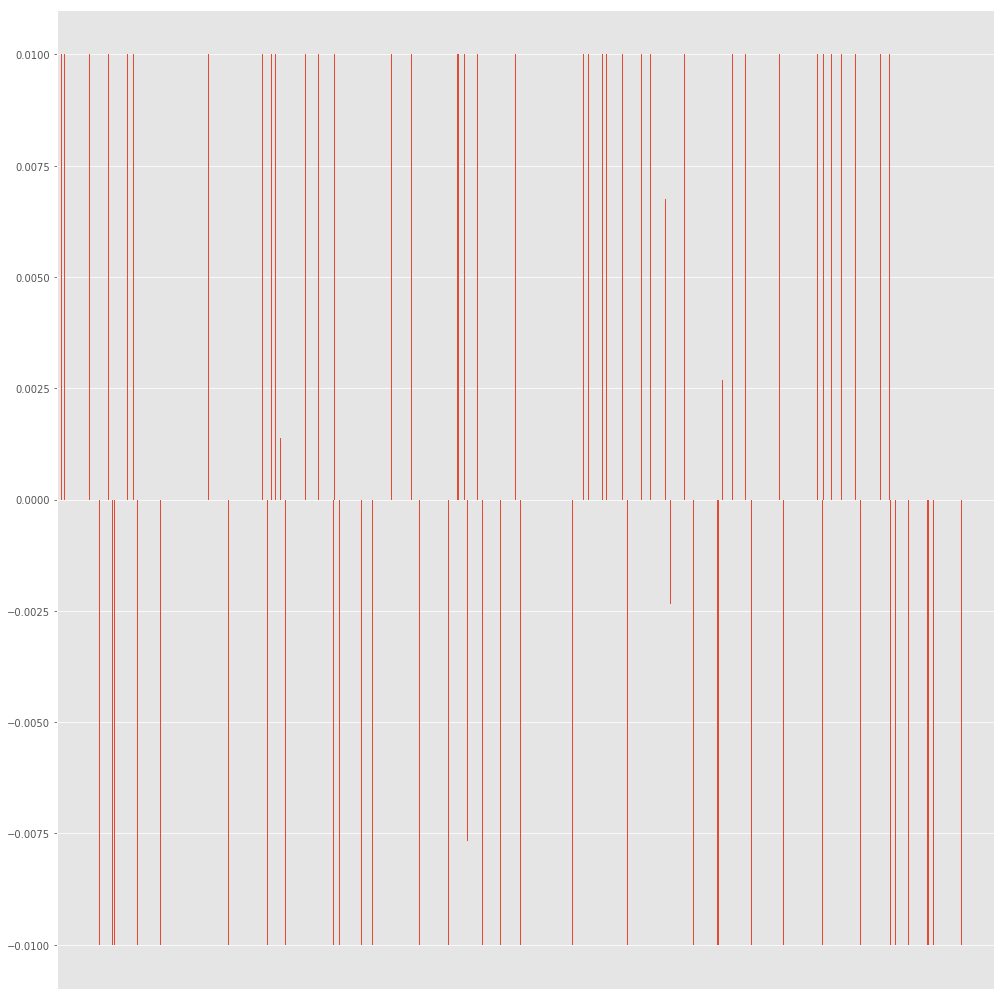

In [107]:
(result).plot.bar(legend=False)
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [200]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, previous, lambda_reg=1.0)
oh._get_obj()

True


True
True


/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


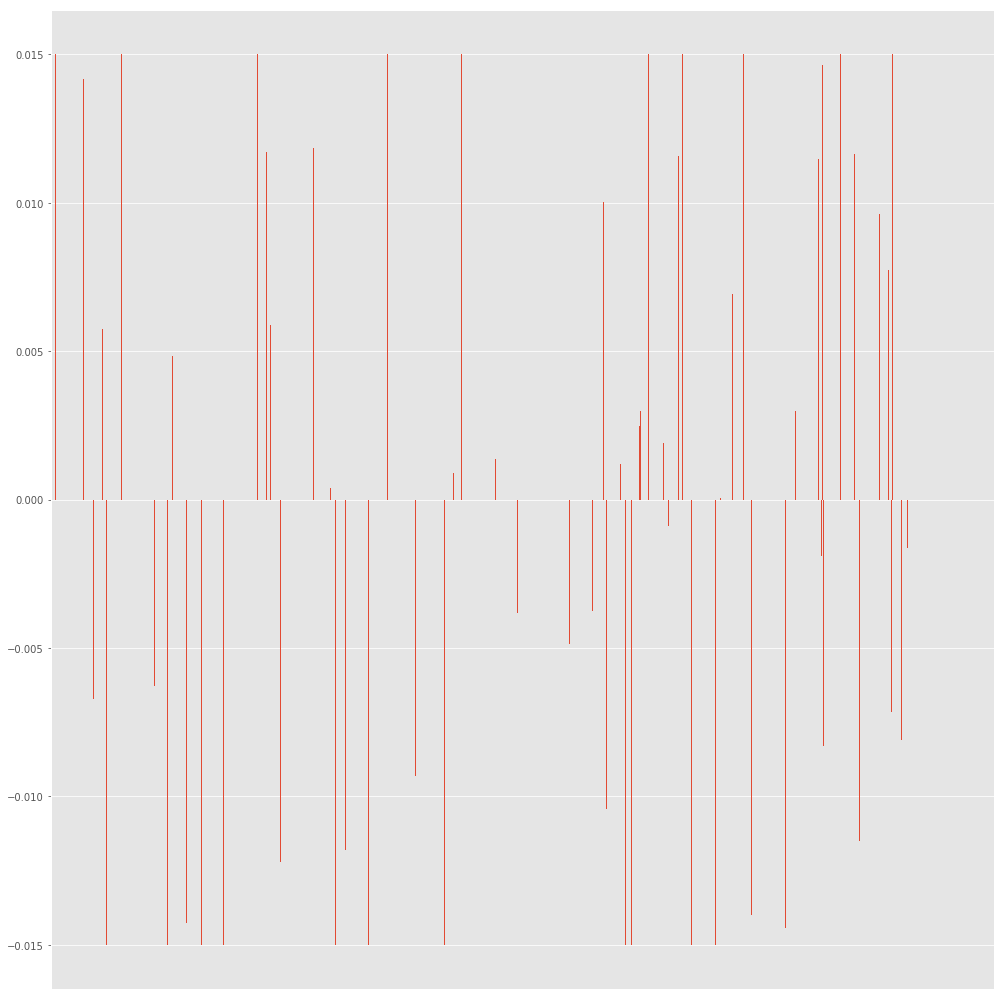

In [201]:
result = oh.find()
(result).plot.bar(legend=False)
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()

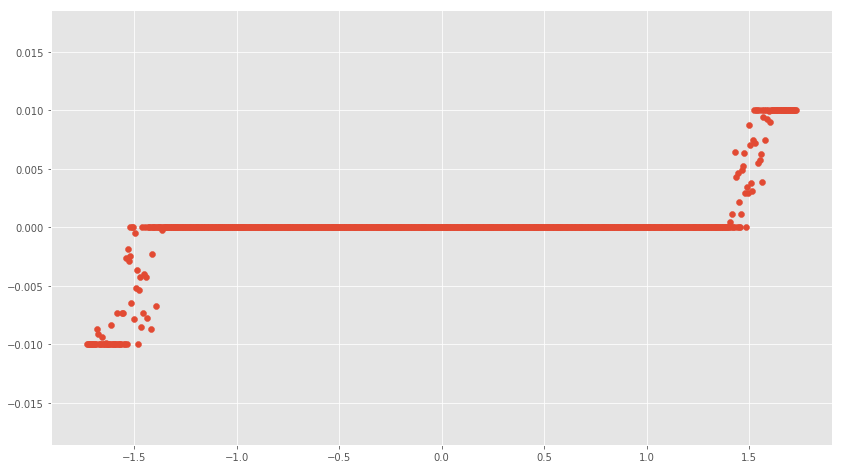

In [113]:
plt.scatter(oh.alpha_vector, result)

In [114]:
print(len(alpha_vector))
print(len(result))
print(alpha_vector.head())
print(result.head())

741
741
ticker
CSCO   -0.471847
UAL    -1.326777
TROW   -0.228916
ISRG    1.691173
NVR    -0.369068
Name: 2012-01-05 00:00:00, dtype: float64
                   0
ticker              
CSCO    1.333379e-11
UAL     3.681273e-11
TROW    5.984465e-12
ISRG    1.000000e-02
NVR     1.068318e-11


In [132]:
def get_transfer_coefficient(a, b):
    tc, p = pearsonr(np.matrix(a, dtype='float').T, np.matrix(b, dtype='float'))
    return tc

In [154]:
av = alpha_vector.values.reshape(len(alpha_vector), 1)
r = result.values
print(av.shape)
print(r.shape)

(741, 1)
(741, 1)


In [160]:
spearmanr(av, r) # not good possibly because too many values are zero in holdings

SpearmanrResult(correlation=-0.14097996530965748, pvalue=0.00011791174535234159)

In [166]:
rank_av = alpha_vector.rank().values.reshape(741, 1)
rank_av.shape

(741, 1)

In [167]:
rank_r = result.rank().values
rank_r.shape

(741, 1)

In [182]:
test_period = momentum.loc[momentum.index.year==2015].index[:3]
test_period

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06'], dtype='datetime64[ns]', name='Date', freq=None)

In [207]:
initial_holdings = pd.DataFrame(np.zeros((len(alpha_vector), 1)), index=momentum.columns)
print(initial_holdings.shape)
initial_holdings.head()

(741, 1)


,0
ticker,
CSCO,0.0
UAL,0.0
TROW,0.0
ISRG,0.0
NVR,0.0


In [216]:

def backtest(holdings, days, alpha, aum):
    port = {}
    
    test_period = alpha.loc[alpha.index.year==2015].index[:days]
    for d in test_period:
        str_d = d.strftime('%Y%m%d')
        end_date = d
        start_date = d - dt.timedelta(days=365)
        av = alpha.loc[end_date, :]
        rets = returns.loc[start_date:end_date, :]
        lambda_vector = np.ones((len(av), 1)) * 0.1/2000000
        rm = RiskModelPCA(rets)
        oh = OptimalHoldingsCVX(rm, av, holdings, lambda_reg=1.0)
        new_holdings = oh.find()
        print('old holdings shape: ', holdings.shape)
        print('new holdings shape: ', new_holdings.shape)
        print('alpha vector shape: ', av.shape)
        print('risk factors shape: ', rm.factor_exposures.shape)
        risk_exposures = pd.Series(np.matmul(rm.factor_exposures.T, new_holdings), 
                                   index=rm.factor_exposures.columns) * aum
        alpha_exposures = pd.Series(np.matmul(av.T, new_holdings), index=av.columns) * aum
        transaction_costs = np.dot(lambda_vector, (new_holdings - holdings)**2) * aum
        result = {
            'h.opt.previous': np.nan_to_num(holdings),
            'h.opt': np.nan_to_num(new_holdings),
            'risk.exposures': risk_exposures,
            'alpha.exposures': alpha_exposures,
            't.costs': transaction_costs
        }
        port[str_d] = result
        holdings = new_holdings
    return port

In [ ]:
port = backtest(initial_holdings, 1, momentum, 50000000)

True
True


In [209]:
for key in port.keys():
    print(port[key])
    break

[0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.00134952

In [211]:
rm.factor_exposures

,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,factor_17,factor_18,factor_19
ticker,,,,,,,,,,,,,,,,,,,,
CSCO,-0.025491,-0.004822,-0.021327,9.535643e-03,-0.006195,-0.008327,-0.058867,-0.002168,0.034237,-0.009771,0.001749,-0.002017,-0.001055,-0.002996,0.028962,-0.007944,0.013295,-0.001201,-0.010307,-0.021215
UAL,-0.050543,0.119372,-0.023852,2.436096e-02,-0.202409,-0.070563,-0.019069,0.116502,-0.127779,0.168108,-0.007145,-0.080033,-0.111501,-0.067765,-0.016816,0.050011,-0.079449,0.036189,0.027830,-0.088080
TROW,-0.038235,0.002244,-0.029069,1.366885e-03,0.002251,-0.016126,0.005845,0.002050,0.003080,-0.020090,-0.005023,-0.032173,-0.025396,0.020535,0.001685,-0.009782,-0.017796,-0.043235,-0.017539,0.005712
ISRG,-0.036265,0.019723,0.027763,-3.692928e-03,-0.004052,0.005892,0.012618,-0.004363,-0.011002,-0.089301,0.003281,0.020477,0.004211,-0.055162,0.000317,0.052629,-0.136822,0.134967,-0.053386,0.065767
NVR,-0.018124,0.009504,-0.009621,-2.539877e-02,-0.048739,0.050162,-0.013446,-0.016796,-0.059555,-0.022124,0.022897,-0.076381,0.023081,0.039716,0.025207,0.047959,-0.045725,0.030287,0.050402,0.062580
PRGO,-0.032560,0.047305,0.055054,-4.137898e-02,-0.029332,-0.020588,0.023896,-0.054849,0.012596,-0.014519,0.033477,0.075817,0.014022,0.030494,-0.014194,-0.013837,0.030999,0.068017,0.018501,0.048309
LECO,-0.043323,-0.020624,-0.006356,-2.516521e-03,0.004935,0.012157,-0.023952,-0.016892,-0.028318,-0.007341,0.007595,0.042994,0.015365,0.009114,-0.024629,0.013282,-0.011330,0.002519,-0.055782,-0.021466
TPR,-0.021607,0.011113,-0.026946,1.758957e-02,0.022723,0.119835,0.052905,-0.047055,-0.037177,-0.038590,-0.024133,0.014440,0.087411,-0.033261,0.021689,-0.006103,0.050176,-0.055474,0.044544,-0.039595
DVN,-0.045655,-0.126007,0.024197,-7.958130e-03,0.009840,-0.019958,0.035591,0.062661,0.036972,-0.027548,0.017173,0.002900,0.024534,0.045038,0.014310,0.012047,-0.015425,0.001879,0.025776,0.043782
